In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy
from cvxpy.constraints.constraint import Constraint
from cvxpy.problems.problem import Problem

matplotlib.rcParams["text.usetex"] = True
sns.set_style("whitegrid")

In [4]:
asinh = lambda x: np.log(x + (x**2 + 1.)**(0.5))
Gj = lambda x, k: asinh( (x/k)**0.5 )
G = lambda x, ks:  2. * sum([ Gj(x, k) for k in ks ])
Ej = lambda x, k: 1. / k * (1. + (1. + k/x)**0.5)/2.
fluxJ = lambda x, ks: 1 / sum([ Ej(x, k) for k in ks ])

norm = lambda y, ks: sum([k**y for k in ks])**(1/y)
n_one = lambda ks: 1/norm(-1, ks)
n_half = lambda ks: 1/norm(-0.5, ks)

In [5]:
plt.cm.Accent(1)

(0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1.0)

# Exact solution vs. approximate

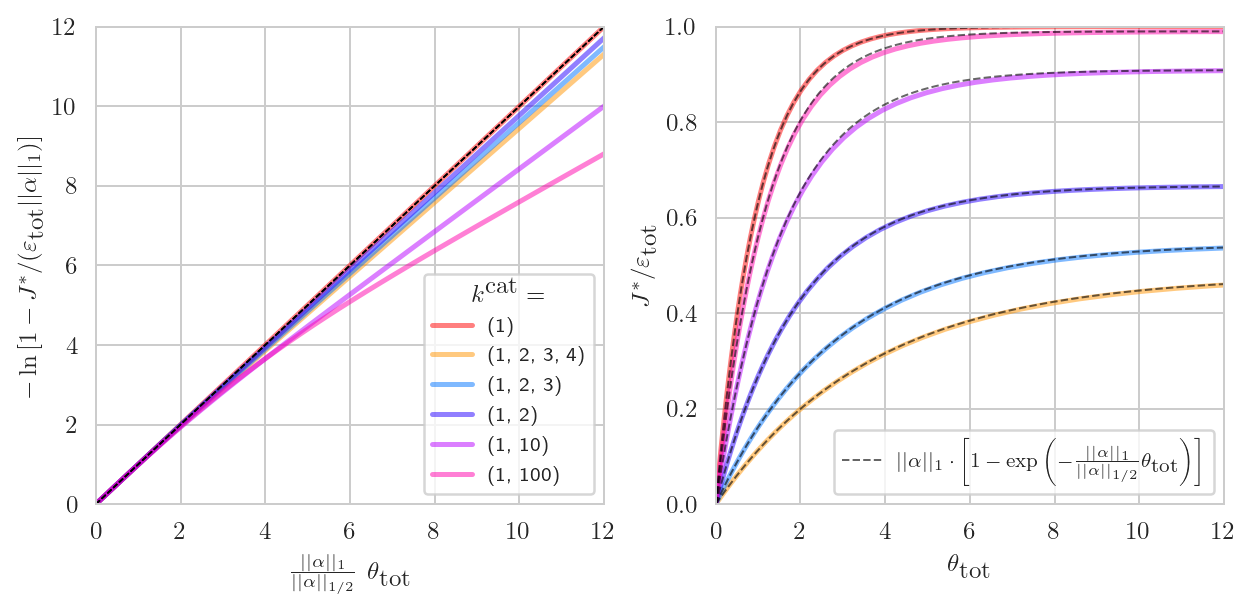

In [6]:
psi_range = np.logspace(-5, 5, 100)
theta_tot_range = np.linspace(0, 12, 100)

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), dpi=180)

kcat_list = [
    [1.],
    [1., 2., 3., 4.],
    [1., 2., 3.],
    [1., 2.],
    [1., 10.],
    [1., 100.],
]
cmap = plt.cm.hsv([0, 0.1, 0.6, 0.7, 0.8, 0.9], alpha=0.5)
axs[0].set_prop_cycle('color', cmap)
axs[1].set_prop_cycle('color', cmap)

for kcats in map(np.array, kcat_list):
    # exponential appxoatimation
    axs[0].plot(
        G(psi_range, kcats)*n_one(kcats)/n_half(kcats), -np.log(1 - fluxJ(psi_range, kcats)*n_one(kcats)), linewidth=2,
        label="(" + ', '.join([str(int(k)) for k in kcats]) + ")",
    )
    axs[1].plot(
        G(psi_range, kcats), fluxJ(psi_range, kcats), linewidth=2,
    )

for i, kcats in enumerate(map(np.array, kcat_list)):
    axs[0].plot([0, 12], [0, 12], 'k--', alpha=0.6, linewidth=0.6)
    axs[1].plot(
        theta_tot_range, [1/n_one(kcats)*(1 - np.exp(-n_one(kcats)/n_half(kcats)*t)) for t in theta_tot_range], 'k--', alpha=0.6, linewidth=0.8,
        label=(r"$||\alpha||_1 \cdot \left[1 - \exp{\left(-\frac{||\alpha||_1}{||\alpha||_{1/2}} \theta_\textrm{tot}\right)} \right]$" if i == 0 else None)
    )


#ax.set_yscale("log")
axs[0].set_xlim(0, 12)
axs[0].set_ylim(0, 12)
axs[0].set_xlabel(r"$\frac{||\alpha||_1}{||\alpha||_{1/2}}~\theta_\textrm{tot}$")
axs[0].set_ylabel(r"$-\ln{\left[1 - J^* / (\varepsilon_\textrm{tot}||\alpha||_1) \right]}$")

axs[1].set_xlim(0, 12)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel(r"$\theta_\textrm{tot}$")
axs[1].set_ylabel(r"$J^* / \varepsilon_\textrm{tot}$")
axs[0].legend(title=r"$k^\textrm{cat} =$", fontsize=8, loc="lower right")
axs[1].legend(fontsize=8, loc="lower right")

fig.tight_layout()
fig.savefig("../figures/thermo_solution_approximation1.pdf")

## Convex optimization

Compare the exact solution and the approximation to what we get using a convex optimization solver (CVXPY)

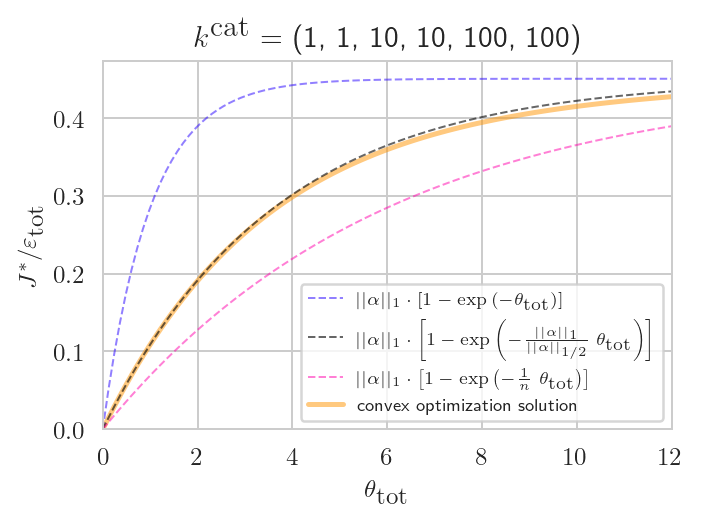

In [7]:
kcats = np.array([1, 1, 10, 10, 100, 100], dtype=float)

n = kcats.shape[0]
driving_forces = cvxpy.Variable(shape=n, name="theta")
log_epsilons = -np.log(kcats) - cvxpy.log(1. - cvxpy.exp(-driving_forces))
e_tot = cvxpy.log_sum_exp(log_epsilons)
obj = cvxpy.Minimize(e_tot)

def approximation(theta_tot: float) -> float:
    return 1/n_one(kcats)*(1 - np.exp(-n_one(kcats)/n_half(kcats)*theta_tot))
def solve_using_ecm(theta_tot: float) -> float:
    constraints = [
        cvxpy.sum(driving_forces) == theta_tot,
        driving_forces >= 1e-5,
    ]
    prob = Problem(objective=cvxpy.Minimize(e_tot), constraints=constraints)
    return np.exp(-prob.solve())

psi_range = np.logspace(-5, 2, 100)
theta_tot_range = np.linspace(0, 12, 100)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=180)
cmap = plt.cm.hsv([0.7, 0.9, 0.1], alpha=0.5)
ax.set_prop_cycle('color', cmap)

ax.plot(
    theta_tot_range, 1/n_one(kcats)*(1 - np.exp(-theta_tot_range)), '--', linewidth=0.8,
    label=r"$||\alpha||_1 \cdot \left[1 - \exp{\left(-\theta_\textrm{tot}\right)} \right]$",
    zorder=2,
)
ax.plot(
    theta_tot_range, [approximation(t) for t in theta_tot_range], 'k--', alpha=0.6, linewidth=0.8,
    label=r"$||\alpha||_1 \cdot \left[1 - \exp{\left(-\frac{||\alpha||_1}{||\alpha||_{1/2}} ~\theta_\textrm{tot}\right)} \right]$",
    zorder=2,
)
ax.plot(
    theta_tot_range, 1/n_one(kcats)*(1 - np.exp(-theta_tot_range/n)), '--', linewidth=0.8,
    label=r"$||\alpha||_1 \cdot \left[1 - \exp{\left(-\frac{1}{n}~\theta_\textrm{tot}\right)} \right]$",
    zorder=2,
)
ax.plot(
    theta_tot_range, [solve_using_ecm(t) for t in theta_tot_range], linewidth=2,
    label="convex optimization solution",
    zorder=1,
)

ax.set_xlim(0, 12)
ax.set_ylim(0, None)
ax.set_title(r"$k^\textrm{cat}$ = (" + ', '.join([str(int(k)) for k in kcats]) + ")")
ax.set_xlabel(r"$\theta_\textrm{tot}$")
ax.set_ylabel(r"$J^* / \varepsilon_\textrm{tot}$")
ax.legend(fontsize=7)
fig.tight_layout()
fig.savefig("../figures/thermo_solution_approximation2.pdf")

# More plots of the approximation

In [8]:
f1 = lambda k, t, ks: 1. - np.exp(-(k*n_half(ks))**(0.5) * t)
f2 = lambda t, ks: 1 / sum([ 1./(k * f1(k, t, ks)) for k in ks ])
approx1 = lambda x, ks: n_one(ks) * ( 1. - np.exp(-n_half(ks)/n_one(ks)*x) )
approx2 = lambda ts, ks: np.array([f2(t, ks) for t in ts])

def plot_approximations(ax, kcats: np.ndarray, e_tot=1.0):
    psi_range = np.logspace(-5, 2, 100)
    theta_tot_range = np.linspace(0, 10, 100)
    
    ax.plot(
        G(psi_range, kcats), e_tot*fluxJ(psi_range, kcats), '-', color=(0.9, 0.9, 0.4), label=r"$J^*$", linewidth=3,
    )
    ax.plot(
        theta_tot_range, e_tot*theta_tot_range*n_half(kcats), '-', linewidth=0.5, color="red",
        label=r"$J^* \approx \varepsilon_{tot} \theta_{tot} \big/ ||\alpha||_{1/2} $"
    )
    ax.plot(
        theta_tot_range, e_tot*n_one(kcats)*np.ones(theta_tot_range.shape), '-', linewidth=0.5,
        color="blue", label=r"$\theta_i \leftarrow \infty$"
    )
    
    # exponential appxoatimation
    ax.plot(
        theta_tot_range, e_tot*approx1(theta_tot_range, kcats), '--', color="darkviolet",
        label=r"$\theta_i \leftarrow ||\alpha||_1/||\alpha||_{1/2} \cdot \theta_{tot}$",
        alpha=0.5,
    )
    
    
    # new approximation (Taylor expantion of asinh(x) ~ x)
    
    ax.plot(
        theta_tot_range, e_tot*approx2(theta_tot_range, kcats), '--', color="navy",
        label=r"$\theta_i \leftarrow \sqrt{\alpha_i/||\alpha||_{1/2}} \cdot \theta_{tot}$",
        alpha=0.5,
    )
    
    ax.plot(
        theta_tot_range, e_tot * n_one(kcats) * (1 - np.exp(-theta_tot_range/kcats.shape[0])), '--', color="coral",
        label=r"$\theta_i \leftarrow \theta_{tot}/n$",
        alpha=0.5,
    )
    
    # now plot the precise solution:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1.1*e_tot*n_one(kcats))
    ax.set_xlabel(r"$\theta_{tot}$")
    ax.set_ylabel(r"$J^*$")
    ax.set_title(r"$\varepsilon_{tot}$ = " + f"{e_tot}" + r", $k^{cat}$ = " + f"{kcats.round(3)}")
    ax.legend()

/tmp/ipykernel_248323/435605710.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  f2 = lambda t, ks: 1 / sum([ 1./(k * f1(k, t, ks)) for k in ks ])


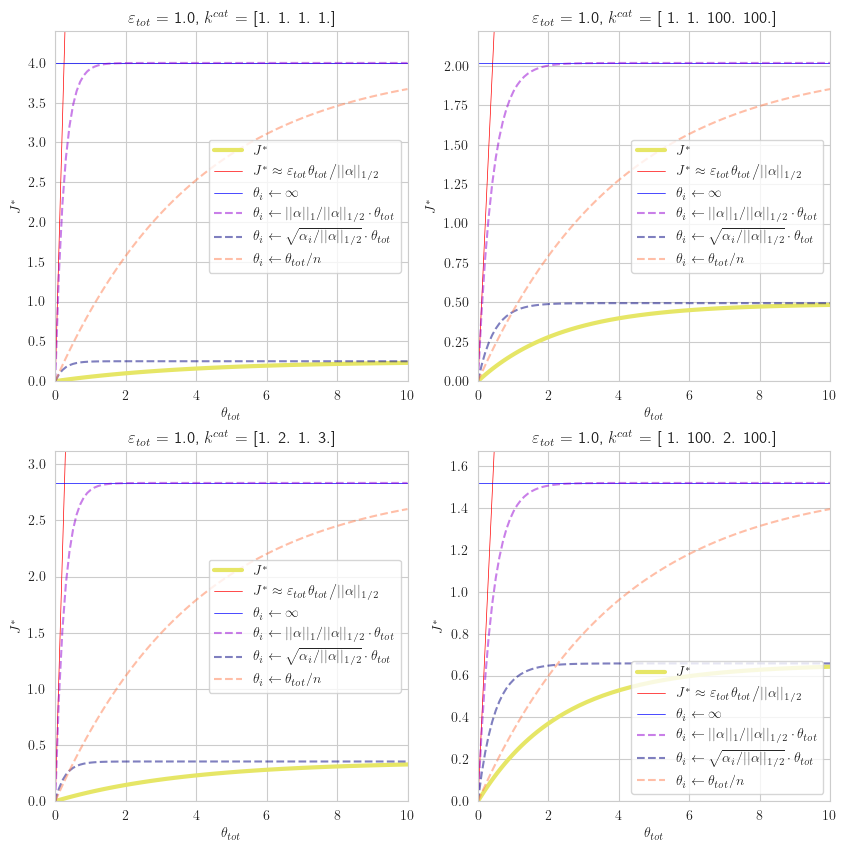

In [9]:
np.random.seed(2019)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

plot_approximations(axs[0, 0], np.array([1, 1, 1, 1], dtype=float), e_tot=1.0)
plot_approximations(axs[0, 1], np.array([1, 1, 100, 100], dtype=float), e_tot=1.0)
plot_approximations(axs[1, 0], np.array([1, 2, 1, 3], dtype=float), e_tot=1.0)
plot_approximations(axs[1, 1], np.array([1, 100, 2, 100], dtype=float), e_tot=1.0)